# Tuning Neural Networks in Keras

We will use the version of Keras that comes in the Tensorflow package, as it has the most up to date tools.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from seaborn import heatmap

from sklearn.metrics import mean_squared_error, classification_report, \
ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(2)

### Plot History

Since we will be plotting histories for all of our models, lets create a function to do it quickly.

In [2]:
def evaluate_classification(y_true, y_pred, labels=None, normalize=None):
  print(classification_report(y_true, y_pred, target_names=labels))

  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                          display_labels=labels, 
                                          normalize=normalize,
                                          cmap='Blues')
  plt.show()

In [3]:
#  You can use this function to see how your model improves over time
def plot_history(history, metrics=None):
  plt.plot(history.history['loss'], label='training')
  plt.plot(history.history['val_loss'], label='testing')
  plt.title('Loss')
  plt.legend()
  plt.show()
  if metrics:
    for metric in metrics:
      plt.plot(history.history[metric], label=f'training {metric}')
      plt.plot(history.history[f'val_{metric}'], label=f'testing {metric}')
      plt.legend()
      plt.title(metric)
      plt.show()



# Classification:

Classification models are similar, except that we need to adjust the final activation of the output layer, the loss function in the compile step, and the metrics we use to judge them.  Remember: MAE, MSE, RMSE, and R2 are regression metrics, accuracy, recall, precision, F1-Score, and confusion matrices are classification metrics.

## Classification Dataset
The classification dataset describes diabetes rates among Pima Indians.  Each row is a person and this dataset and includes features regarding health related measurements.  The target binary and represents whether or not a person will diagnosed with diabetes.  This is another old dataset first presented in 1988.



In [4]:
classification_df = pd.read_csv('https://raw.githubusercontent.com/ninja-josh/image-storage/main/diabetes.csv')
classification_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
classification_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
classification_df.duplicated().any()

False

In [7]:
classification_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We see minimums for Glucose, BloodPression, SkinThickness, Insulin, and BMI of 0s.  Those are impossible for humans, so lets drop those rows.

In [8]:
no_glucose = classification_df['Glucose'] == 0
no_blood = classification_df['BloodPressure'] == 0
no_skin = classification_df['SkinThickness'] == 0
no_insulin = classification_df['Insulin'] == 0
no_bmi = classification_df['BMI'] == 0

#class_df_clean excludes rows that have no values == 0 in the above columns
class_df_clean = classification_df[~(no_glucose |
                                     no_blood |
                                     no_skin |
                                     no_insulin |
                                     no_bmi)]
class_df_clean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We lost a lot of data, going from 768 samples to 392 samples.  In the future we might impute this data using means, medians, or other imputation strategies.  For this exercise we won't focus on that.

In [9]:
# Define X and y and train test split
X = class_df_clean.drop(columns = 'Outcome')
y = class_df_clean['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [10]:
# Scale
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Classification Model

We need to do a few things differently here:

Since this is a binary classification, the activation of our final layer needs to be 'sigmoid'.  If this were multiclass we would set this as 'softmax' and the number of output nodes would be the number of classes in our y_train.



In [11]:
# Build your model
# Create your model
class_model = Sequential()
class_model.add(Dense(10, activation = 'relu', input_dim = X_train.shape[1]))
class_model.add(Dense(10, activation = 'relu'))
class_model.add(Dense(1, activation = 'sigmoid'))

We need to change our loss to 'binary_crossentropy'.  If this were multiclass we would use 'categorical_crossentrobpy'.

Since MSE is a regression metric, not a classification metric, we change the metric to accuracy.  We could also use recall or precision. 

In [12]:
# Compile your model, to use our custom function, set metrics = ['acc']
class_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [13]:
# fit your model
history = class_model.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100,
                        verbose=0)

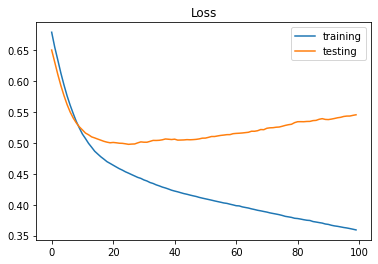

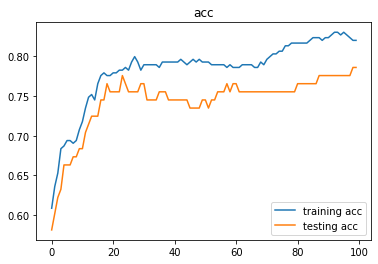

In [14]:
# See how your model is doing
plot_history(history, ['acc'])

## Evaluation



Training Evaluation:

              precision    recall  f1-score   support

 No Diabetes       0.87      0.86      0.86       196
    Diabetes       0.73      0.73      0.73        98

    accuracy                           0.82       294
   macro avg       0.80      0.80      0.80       294
weighted avg       0.82      0.82      0.82       294



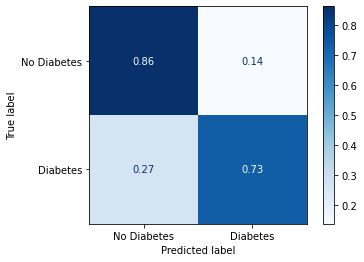

Testing Evaluation:

              precision    recall  f1-score   support

 No Diabetes       0.86      0.82      0.84        66
    Diabetes       0.66      0.72      0.69        32

    accuracy                           0.79        98
   macro avg       0.76      0.77      0.76        98
weighted avg       0.79      0.79      0.79        98



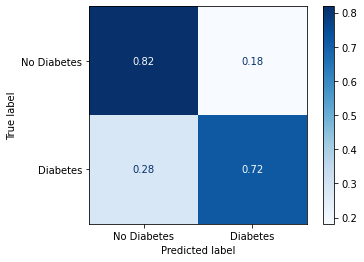

In [15]:
# Make predictions and evaluate your model
# Define labels for the confusion matrix
labels = ['No Diabetes', 'Diabetes']

# Get predictions and round them to integers instead of floats
train_preds = np.rint(class_model.predict(X_train))
test_preds = np.rint(class_model.predict(X_test))

# Evaluate training set
print('Training Evaluation:\n')
evaluate_classification(y_train, train_preds, labels=labels,
                        normalize='true')
print('Testing Evaluation:\n')
# Confusion Matrix
evaluate_classification(y_test, test_preds, labels=labels,
                        normalize='true')

# 👉 Improving an underfit model:
##Increase model complexity:
1. add layers  
2. add nodes 
3. reduce other regularization

# 👉 Improving an overfit model:
## Reduce model complexity:
1. Reduce layers or nodes
2. Add dropout layers
3. Implement early stopping callback
3. Add L1 or L2 regularization


# 💪 Your Turn: Improve this model!

* Choose one or more regularization techniques to improve this model.

* Make one change at a time.  Make a new cell for each change to keep a record of what you've tried.

##Ask yourself:  Should we increase or decrease model complexity?



# Adding Dropout layers

In [16]:
from keras.layers import Dropout
# Build your model
# Create your model
n_cols = X_train.shape[1]
class_model2 = Sequential()
class_model2.add(Dense(10, activation = 'relu', input_dim = X_train.shape[1]))
class_model2.add(Dropout(.1))
class_model2.add(Dense(10, activation = 'relu'))
class_model2.add(Dropout(.1))

class_model2.add(Dense(1, activation = 'sigmoid'))

# Compile your model, to use our custom function, set metrics = ['acc']
class_model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])


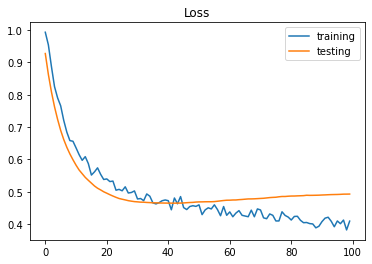

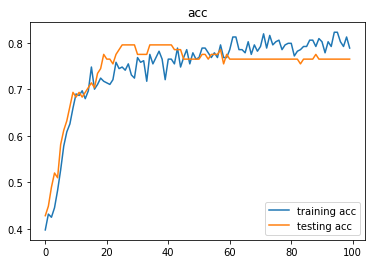

In [17]:
# fit your model
history = class_model2.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100,
                        verbose=0)

# See how your model is doing
plot_history(history, ['acc'])

# Early Stopping

In [18]:
from keras.callbacks import EarlyStopping

# Build your model

class_model3 = Sequential()
class_model3.add(Dense(10, activation = 'relu', input_dim = X_train.shape[1]))
class_model3.add(Dense(10, activation = 'relu'))
class_model3.add(Dense(1, activation = 'sigmoid'))

# Compile your model, to use our custom function, set metrics = ['acc']
class_model3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])


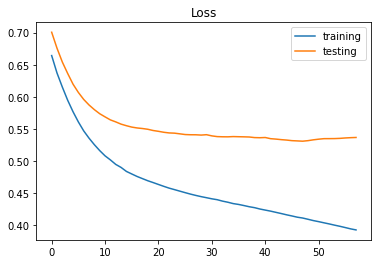

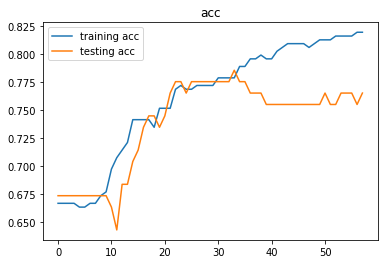

In [19]:
# fit your model
history = class_model3.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100,
                        callbacks=[EarlyStopping(patience=10)],
                        verbose=0
                           )

# See how your model is doing
plot_history(history, ['acc'])

# Use L1 or L2 Kernel Regularization

Can use 'l1', 'l2' or 'l1_l2'

In [20]:
from keras import regularizers

# Build your model
class_model4 = Sequential()
class_model4.add(Dense(10, activation = 'relu', 
                       input_dim = X_train.shape[1],
                       kernel_regularizer=regularizers.l1_l2(l1=.01, l2=.01)
                      ))
class_model4.add(Dense(10, 
                       activation = 'relu',
                       kernel_regularizer=regularizers.l1(.01)
                      ))
class_model4.add(Dense(1, activation = 'sigmoid'))

# Compile your model, to use our custom function, set metrics = ['acc']
class_model4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])


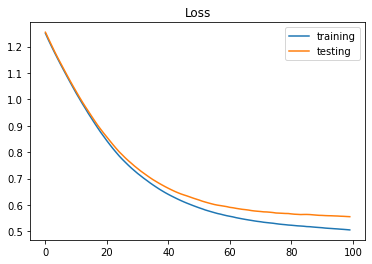

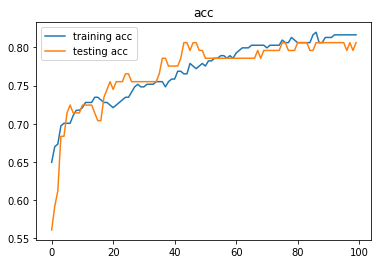

In [21]:
# fit your model
history = class_model4.fit(X_train, y_train,
                           validation_data = (X_test, y_test),
                          epochs = 100,
                           verbose=0
                           )

# See how your model is doing
plot_history(history, ['acc'])

# Change Batch Size

This is an argument in the `.fit()` method

In [22]:
from keras import regularizers

# Build your model
class_model5 = Sequential()
class_model5.add(Dense(10, activation = 'relu', 
                       input_dim = X_train.shape[1],
                      ))
class_model5.add(Dense(10, 
                       activation = 'relu',
                      ))
class_model5.add(Dense(1, activation = 'sigmoid'))

# Compile your model, to use our custom function, set metrics = ['acc']
class_model5.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])


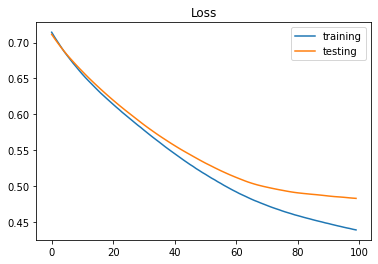

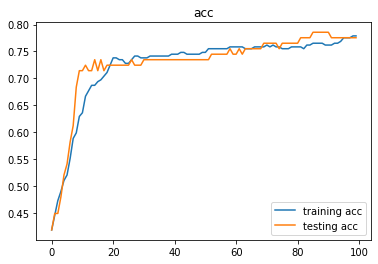

In [23]:
# fit your model
history = class_model5.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100,
                        batch_size=200,
                        verbose=0
                           )

# See how your model is doing
plot_history(history, ['acc'])

# Other Options:
1. Fewer Nodes
2. Just 1 layer instead of 2
3. Fewer Epochs
4. More nodes, layers, and/or epochs, but also more regularization
5. Mixing and matching strategies